In [19]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import requests

def load_image_from_github(raw_url, grayscale=False):
    data = requests.get(raw_url).content
    img = np.frombuffer(data, np.uint8)
    
    if grayscale:
        return cv.imdecode(img, cv.IMREAD_GRAYSCALE)
    else:
        img = cv.imdecode(img, cv.IMREAD_COLOR)
        return cv.cvtColor(img, cv.COLOR_BGR2RGB)


Q1)

In [2]:
runway_url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/img/runway.png"

runway = load_image_from_github(runway_url, grayscale=True)

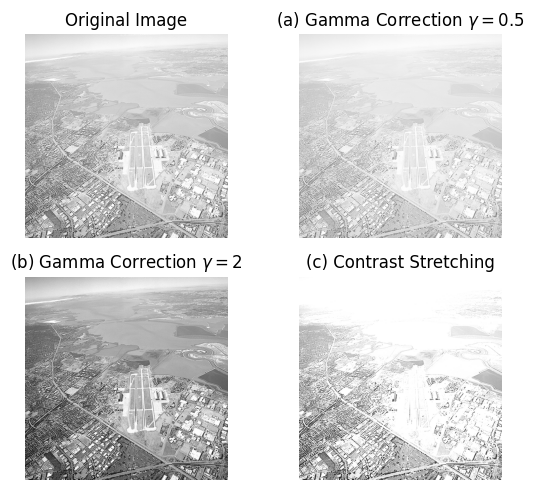

In [24]:

# Normalize to [0, 1]
r = runway / 255.0
# (a) Gamma correction: γ = 0.5
gamma_a = 0.5
img_gamma_05 = np.uint8(np.clip(np.power(r, gamma_a) * 255, 0, 255))

# (b) Gamma correction: γ = 2.0
gamma_b = 2.0
img_gamma_2 = np.uint8(np.clip(np.power(r, gamma_b) * 255, 0, 255))

# (c) Contrast stretching
r1, r2 = 0.2, 0.8
s = np.zeros_like(r)

mask_mid = (r >= r1) & (r <= r2)
s[mask_mid] = (r[mask_mid] - r1) / (r2 - r1)
s[r > r2] = 1.0

img_contrast = np.uint8(np.clip(s * 255, 0, 255))

# Visualization
plt.figure(figsize=(6, 5))

plt.subplot(2, 2, 1)
plt.imshow(runway, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(img_gamma_05, cmap="gray")
plt.title(r"(a) Gamma Correction $\gamma=0.5$")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(img_gamma_2, cmap="gray")
plt.title(r"(b) Gamma Correction $\gamma=2$")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(img_contrast, cmap="gray")
plt.title("(c) Contrast Stretching")
plt.axis("off")

plt.tight_layout()
plt.show()


Q2)

In [6]:
# Load the color highlights_and_shadows.jpg for Question 2
gamma_color_url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/img/highlights_and_shadows.jpg"
color_img = load_image_from_github(gamma_color_url, grayscale=False)

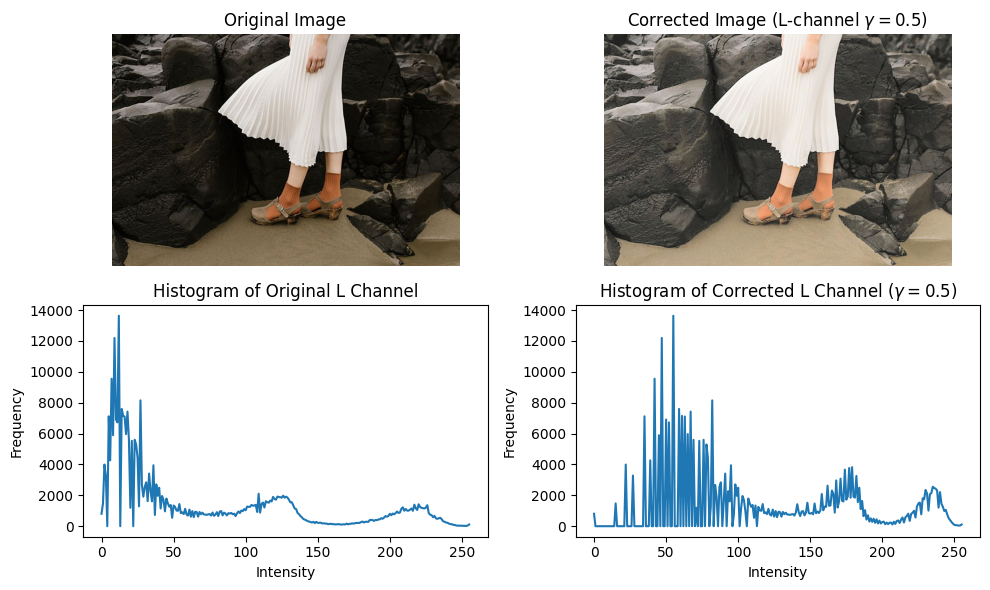

In [12]:
gamma_value = 0.5
# Convert RGB → LAB
img_lab = cv.cvtColor(color_img, cv.COLOR_RGB2LAB)
L, a, b = cv.split(img_lab)
# Gamma correction on L channel
L_norm = L / 255.0
L_gamma = np.uint8(np.clip(np.power(L_norm, gamma_value) * 255, 0, 255))

# Merge channels and convert back to RGB
lab_corrected = cv.merge((L_gamma, a, b))
img_corrected = cv.cvtColor(lab_corrected, cv.COLOR_LAB2RGB)

# Histograms
hist_L_orig = cv.calcHist([L], [0], None, [256], [0, 256])
hist_L_corr = cv.calcHist([L_gamma], [0], None, [256], [0, 256])

# Visualization
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.imshow(color_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(img_corrected)
plt.title(rf"Corrected Image (L-channel $\gamma={gamma_value}$)")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.plot(hist_L_orig)
plt.title("Histogram of Original L Channel")
plt.xlabel("Intensity")
plt.ylabel("Frequency")

plt.subplot(2, 2, 4)
plt.plot(hist_L_corr)
plt.title(rf"Histogram of Corrected L Channel ($\gamma={gamma_value}$)")
plt.xlabel("Intensity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


Q3)

In [5]:
def histogram_equalization(img):
    M, N = img.shape
    total_pixels = M * N

    hist = np.zeros(256, dtype=int)
    for i in range(256):
        hist[i] = np.sum(img == i)

    pdf = hist / total_pixels

    cdf = np.zeros(256, dtype=float)
    current_sum = 0
    for i in range(256):
        current_sum += pdf[i]
        cdf[i] = current_sum

    map_table = np.round(cdf * 255).astype(np.uint8)

    equalized_img = map_table[img]

    return equalized_img

In [9]:
img_orig = runway.copy()
img_eq = histogram_equalization(img_orig)

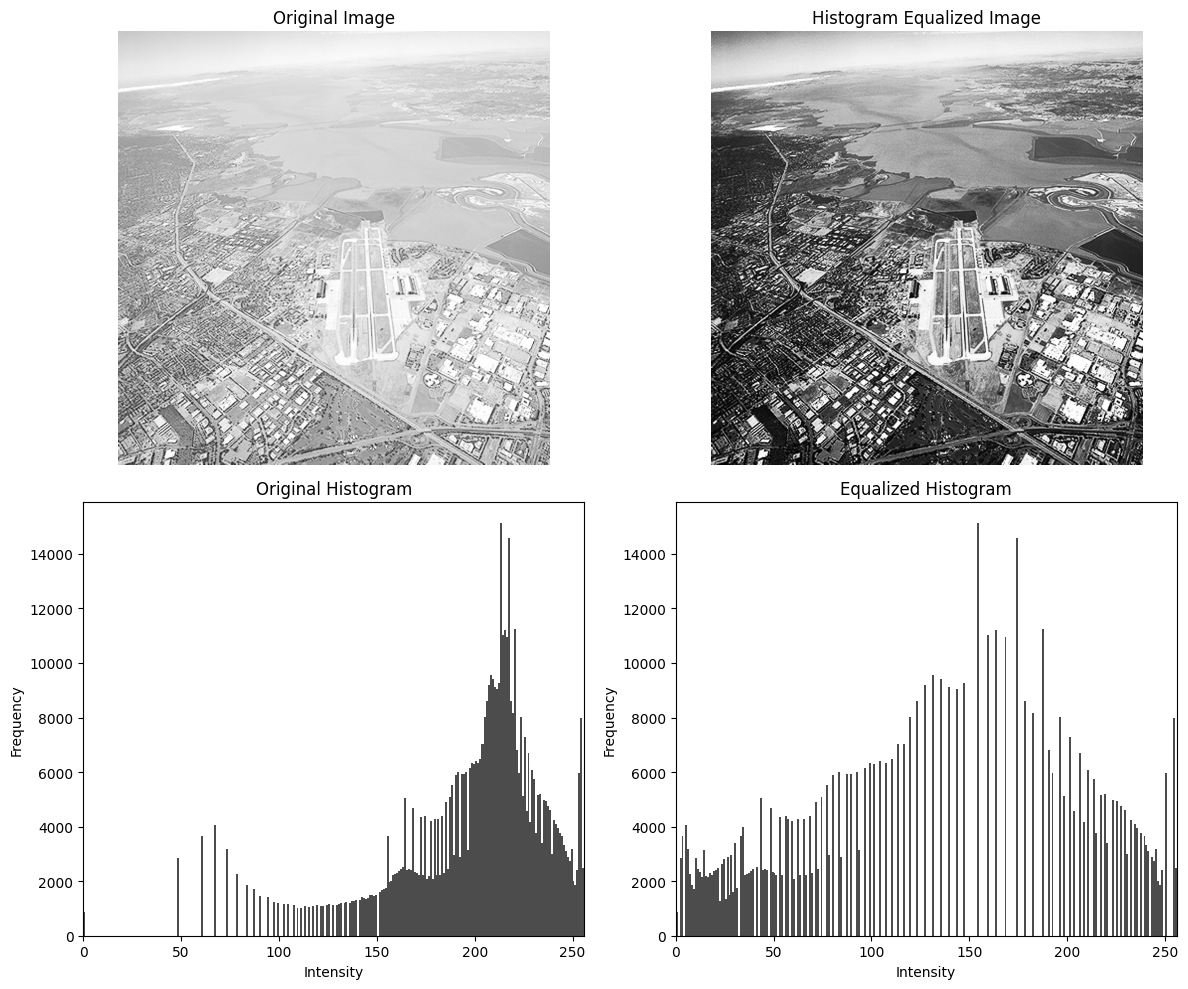

In [11]:
# Visualization
plt.figure(figsize=(12, 10))

# Original Image
plt.subplot(2, 2, 1)
plt.imshow(img_orig, cmap='gray', vmin=0, vmax=255)
plt.title('Original Image')
plt.axis('off')

# Equalized Image
plt.subplot(2, 2, 2)
plt.imshow(img_eq, cmap='gray', vmin=0, vmax=255)
plt.title('Histogram Equalized Image')
plt.axis('off')

# Original Histogram
plt.subplot(2, 2, 3)
plt.hist(img_orig.ravel(), 256, range=[0, 256], color='black', alpha=0.7)
plt.title('Original Histogram')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.xlim([0, 256])

# Equalized Histogram
plt.subplot(2, 2, 4)
plt.hist(img_eq.ravel(), 256, range=[0, 256], color='black', alpha=0.7)
plt.title('Equalized Histogram')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.xlim([0, 256])

plt.tight_layout()
plt.show()


Q4)

Otsu Threshold Value: 101.0


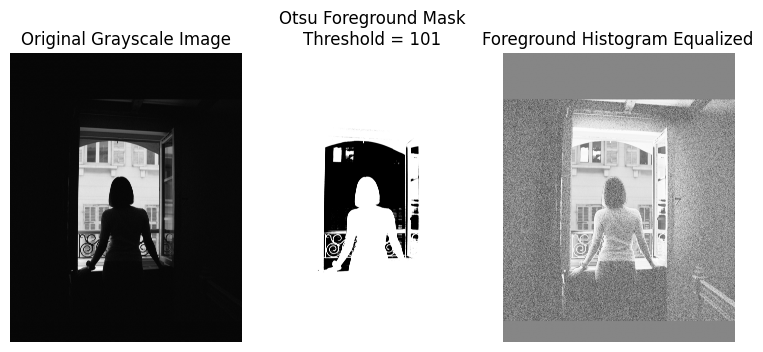

In [13]:
# Load image from GitHub and convert to grayscale
url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/img/looking_out.jpg"

img_rgb = load_image_from_github(url, grayscale=False)
img = cv.cvtColor(img_rgb, cv.COLOR_RGB2GRAY)

# (a) Otsu Thresholding (foreground = woman + room)
otsu_threshold, mask = cv.threshold(
    img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU
)

print("Otsu Threshold Value:", otsu_threshold)

# (b) Histogram Equalization on Foreground Only
foreground_pixels = img[mask == 255]

hist = np.bincount(foreground_pixels, minlength=256)
cdf = hist.cumsum()

cdf_m = np.ma.masked_equal(cdf, 0)
cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
cdf_final = np.ma.filled(cdf_m, 0).astype('uint8')

img_equalized = img.copy()
img_equalized[mask == 255] = cdf_final[img[mask == 255]]

# Visualization
plt.figure(figsize=(10, 4))

plt.subplot(1, 4, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Grayscale Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(mask, cmap="gray")
plt.title(f"Otsu Foreground Mask\nThreshold = {otsu_threshold:.0f}")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(img_equalized, cmap="gray")
plt.title("Foreground Histogram Equalized")
plt.axis("off")

plt.tight_layout()
plt.show()


Q5)

Compute a normalized 5×5 Gaussian kernel (σ = 2)

In [15]:
# (a) Normalized 5×5 Gaussian kernel using NumPy

def gaussian_kernel(size, sigma):
    k = size // 2
    x, y = np.meshgrid(np.arange(-k, k+1), np.arange(-k, k+1))
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel

kernel_5x5 = gaussian_kernel(5, sigma=2)

kernel_5x5


array([[0.02324684, 0.03382395, 0.03832756, 0.03382395, 0.02324684],
       [0.03382395, 0.04921356, 0.05576627, 0.04921356, 0.03382395],
       [0.03832756, 0.05576627, 0.06319146, 0.05576627, 0.03832756],
       [0.03382395, 0.04921356, 0.05576627, 0.04921356, 0.03382395],
       [0.02324684, 0.03382395, 0.03832756, 0.03382395, 0.02324684]])

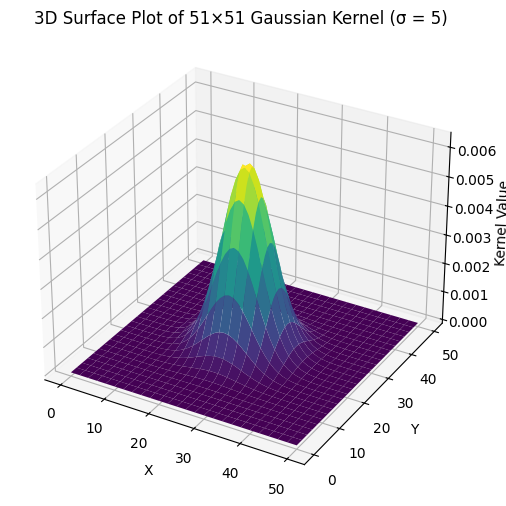

In [17]:
# (b) 3D visualization of 51×51 Gaussian kernel

kernel_51 = gaussian_kernel(51, sigma=5)

x = np.arange(51)
y = np.arange(51)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, kernel_51, cmap='viridis')

ax.set_title("3D Surface Plot of 51×51 Gaussian Kernel (σ = 5)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Kernel Value")

plt.show()


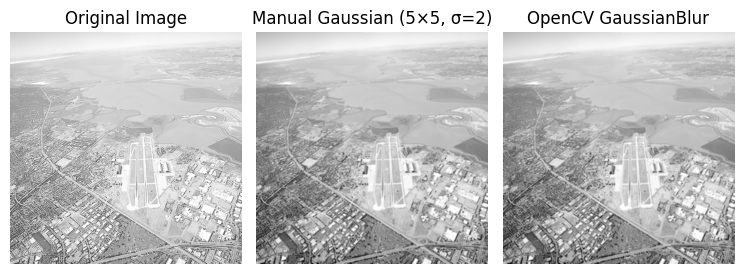

In [15]:
# Load grayscale image
url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/img/runway.png"
img = load_image_from_github(url, grayscale=True)

# Manual Gaussian smoothing
kernel_5x5 = gaussian_kernel(5, sigma=2)
img_manual = cv.filter2D(img, -1, kernel_5x5)

# OpenCV Gaussian smoothing
img_opencv = cv.GaussianBlur(img, (5, 5), sigmaX=2)

# Visualization (3 subplots)
plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(img_manual, cmap='gray')
plt.title("Manual Gaussian (5×5, σ=2)")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(img_opencv, cmap='gray')
plt.title("OpenCV GaussianBlur")
plt.axis("off")

plt.tight_layout()
plt.show()


Q6)

(b) — 5×5 Derivative-of-Gaussian Kernels (σ = 5)

In [8]:
def dog_kernels(size, sigma):
    k = size // 2
    x, y = np.meshgrid(np.arange(-k, k+1), np.arange(-k, k+1))
    
    G = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    G /= G.sum()
    
    Gx = -x / (sigma**2) * G
    Gy = -y / (sigma**2) * G
    
    return Gx, Gy

Gx_5, Gy_5 = dog_kernels(5, sigma=5)

Gx_5, Gy_5


(array([[ 0.00295068,  0.00156657,  0.        , -0.00156657, -0.00295068],
        [ 0.00313314,  0.00166344,  0.        , -0.00166344, -0.00313314],
        [ 0.00319643,  0.00169704,  0.        , -0.00169704, -0.00319643],
        [ 0.00313314,  0.00166344,  0.        , -0.00166344, -0.00313314],
        [ 0.00295068,  0.00156657,  0.        , -0.00156657, -0.00295068]]),
 array([[ 0.00295068,  0.00313314,  0.00319643,  0.00313314,  0.00295068],
        [ 0.00156657,  0.00166344,  0.00169704,  0.00166344,  0.00156657],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [-0.00156657, -0.00166344, -0.00169704, -0.00166344, -0.00156657],
        [-0.00295068, -0.00313314, -0.00319643, -0.00313314, -0.00295068]]))

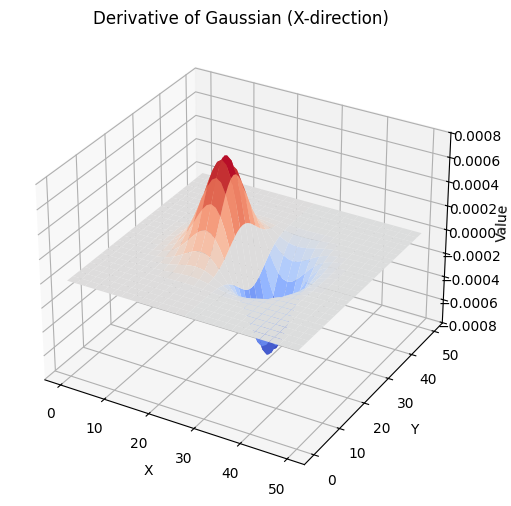

In [9]:
Gx_51, _ = dog_kernels(51, sigma=5)

x = np.arange(51)
y = np.arange(51)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Gx_51, cmap='coolwarm')

ax.set_title("Derivative of Gaussian (X-direction)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Value")

plt.show()


Manual DoG vs Sobel

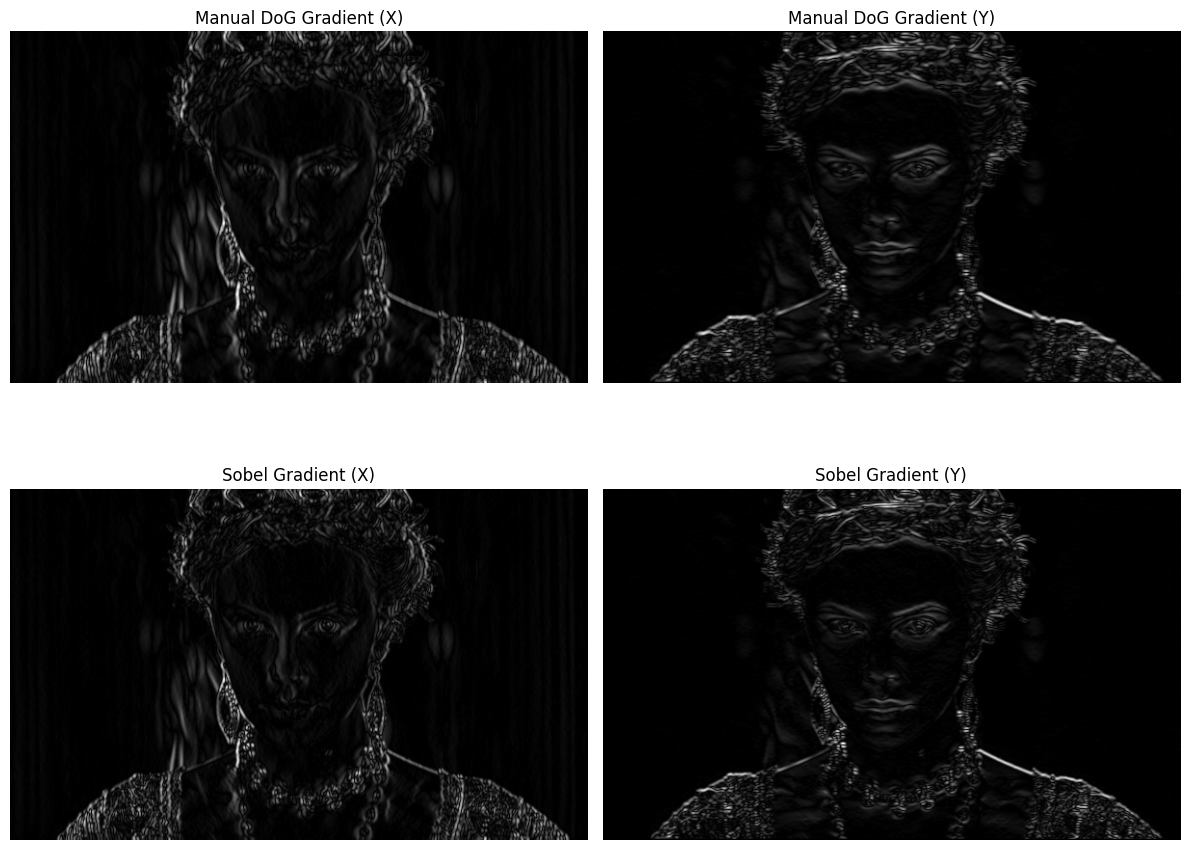

In [11]:
# Load grayscale image
url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/im03small.png"
img_orig = load_image_from_github(url, grayscale=True)


# (d) Apply Manual Derivative of Gaussian (DoG) Kernels

grad_x_dog = cv.filter2D(img_orig, cv.CV_64F, Gx_5)
grad_y_dog = cv.filter2D(img_orig, cv.CV_64F, Gy_5)

# Take absolute values
abs_grad_x_dog = np.abs(grad_x_dog)
abs_grad_y_dog = np.abs(grad_y_dog)

# Normalize for display
disp_x_dog = cv.normalize(abs_grad_x_dog, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
disp_y_dog = cv.normalize(abs_grad_y_dog, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)

# (e) Apply OpenCV Sobel Operator

grad_x_sobel = cv.Sobel(img_orig, cv.CV_64F, 1, 0, ksize=5)
grad_y_sobel = cv.Sobel(img_orig, cv.CV_64F, 0, 1, ksize=5)

disp_x_sobel = cv.normalize(np.abs(grad_x_sobel), None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
disp_y_sobel = cv.normalize(np.abs(grad_y_sobel), None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)

# Visualization

plt.figure(figsize=(12, 10))

# Manual DoG – X
plt.subplot(2, 2, 1)
plt.imshow(disp_x_dog, cmap='gray')
plt.title('Manual DoG Gradient (X)')
plt.axis('off')

# Manual DoG – Y
plt.subplot(2, 2, 2)
plt.imshow(disp_y_dog, cmap='gray')
plt.title('Manual DoG Gradient (Y)')
plt.axis('off')

# Sobel – X
plt.subplot(2, 2, 3)
plt.imshow(disp_x_sobel, cmap='gray')
plt.title('Sobel Gradient (X)')
plt.axis('off')

# Sobel – Y
plt.subplot(2, 2, 4)
plt.imshow(disp_y_sobel, cmap='gray')
plt.title('Sobel Gradient (Y)')
plt.axis('off')

plt.tight_layout()
plt.show()


Q7)

In [33]:

url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/taylor.jpg"
img_orig = load_image_from_github(url, grayscale=True)

url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/taylor_small.jpg"
img_small = load_image_from_github(url, grayscale=True)

In [34]:
def manual_zoom(img, scale_factor, method='nearest'):
    H, W = img.shape

    new_H = int(H * scale_factor)
    new_W = int(W * scale_factor)

    output_img = np.zeros((new_H, new_W), dtype=np.uint8)

    for i_out in range(new_H):
        for j_out in range(new_W):
            r = i_out / scale_factor
            c = j_out / scale_factor

            if method == 'nearest':
                r_near = int(np.round(r))
                c_near = int(np.round(c))

                r_near = min(max(r_near, 0), H - 1)
                c_near = min(max(c_near, 0), W - 1)

                output_img[i_out, j_out] = img[r_near, c_near]

            elif method == 'bilinear':
                r1 = int(np.floor(r))
                c1 = int(np.floor(c))

                r2 = min(r1 + 1, H - 1)
                c2 = min(c1 + 1, W - 1)

                a = r - r1
                b = c - c1

                f_11 = img[r1, c1]
                f_12 = img[r1, c2]
                f_21 = img[r2, c1]
                f_22 = img[r2, c2]

                val = (1 - a) * (1 - b) * f_11 + \
                      (1 - a) * (b) * f_12 + \
                      (a) * (1 - b) * f_21 + \
                      (a) * (b) * f_22

                output_img[i_out, j_out] = int(np.round(val))

    return output_img


In [35]:
def compute_normalized_ssd(img_orig, img_zoomed):
    if img_orig.shape != img_zoomed.shape:
        img_zoomed = cv.resize(
            img_zoomed, (img_orig.shape[1], img_orig.shape[0]))

    arr_orig = img_orig.astype(np.float64)
    arr_zoomed = img_zoomed.astype(np.float64)

    diff_sq = np.sum((arr_orig - arr_zoomed) ** 2)
    norm = np.sum(arr_orig ** 2)

    return diff_sq / norm

In [36]:
scale_factor = img_orig.shape[1] / img_small.shape[1]
print(f"Calculated Scale Factor: {scale_factor:.2f}")

print("Applying Nearest Neighbor Zoom...")
zoom_nn = manual_zoom(img_small, scale_factor, method='nearest')

print("Applying Bilinear Interpolation Zoom...")
zoom_bilinear = manual_zoom(img_small, scale_factor, method='bilinear')

ssd_nn = compute_normalized_ssd(img_orig, zoom_nn)
ssd_bilinear = compute_normalized_ssd(img_orig, zoom_bilinear)

print(f"\nNormalized SSD (Nearest Neighbor): {ssd_nn:.6f}")
print(f"Normalized SSD (Bilinear):         {ssd_bilinear:.6f}")

Calculated Scale Factor: 5.00
Applying Nearest Neighbor Zoom...
Applying Bilinear Interpolation Zoom...

Normalized SSD (Nearest Neighbor): 0.007586
Normalized SSD (Bilinear):         0.006811


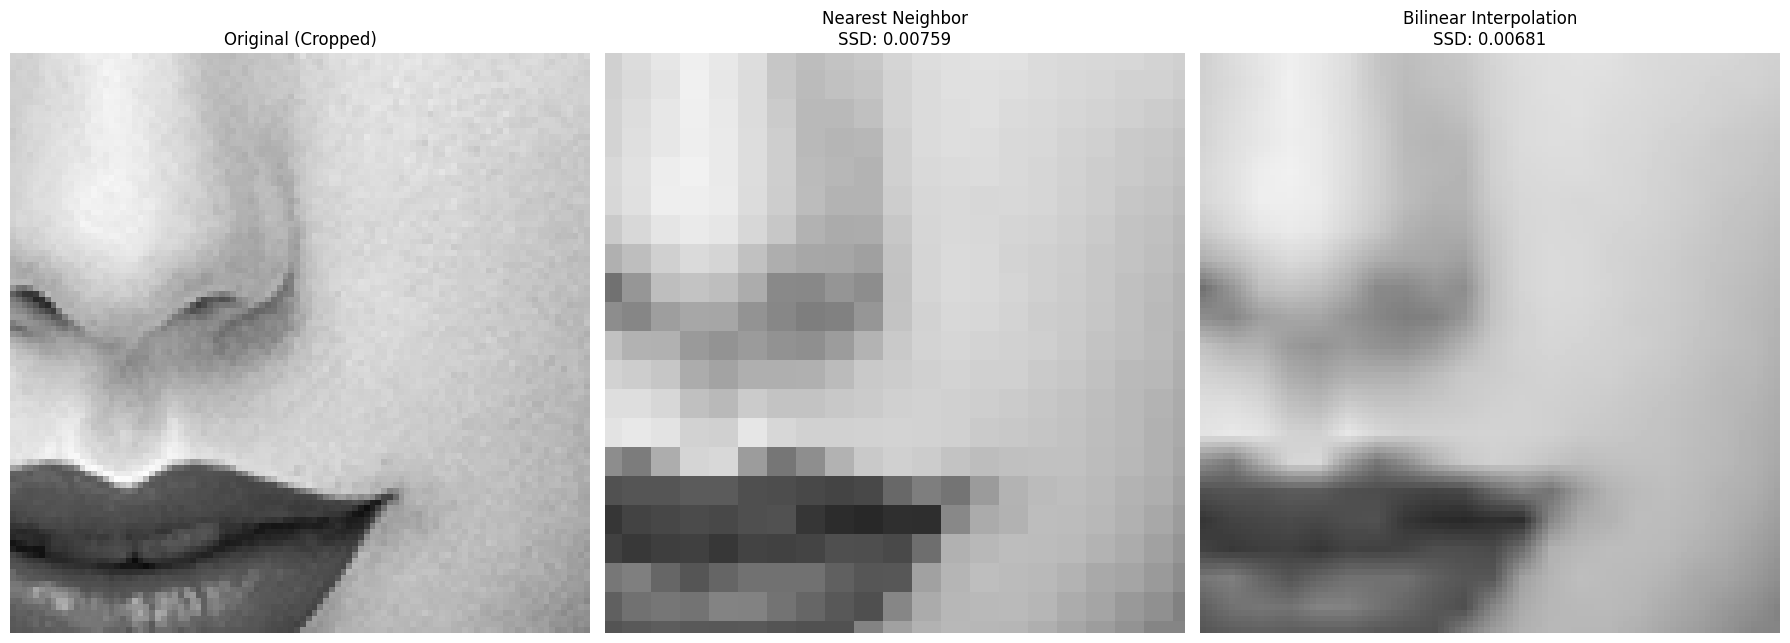

In [37]:
plt.figure(figsize=(18, 8))

h, w = img_orig.shape
crop_y = slice(h//2 - 50, h//2 + 50)
crop_x = slice(w//2 - 50, w//2 + 50)

# Original (cropped)
plt.subplot(1, 3, 1)
plt.imshow(img_orig[crop_y, crop_x], cmap='gray', vmin=0, vmax=255)
plt.title('Original (Cropped)')
plt.axis('off')

# Nearest Neighbor
plt.subplot(1, 3, 2)
plt.imshow(zoom_nn[crop_y, crop_x], cmap='gray', vmin=0, vmax=255)
plt.title(f'Nearest Neighbor\nSSD: {ssd_nn:.5f}')
plt.axis('off')

# Bilinear Interpolation
plt.subplot(1, 3, 3)
plt.imshow(zoom_bilinear[crop_y, crop_x], cmap='gray', vmin=0, vmax=255)
plt.title(f'Bilinear Interpolation\nSSD: {ssd_bilinear:.5f}')
plt.axis('off')

plt.tight_layout()
plt.show()


Q8)

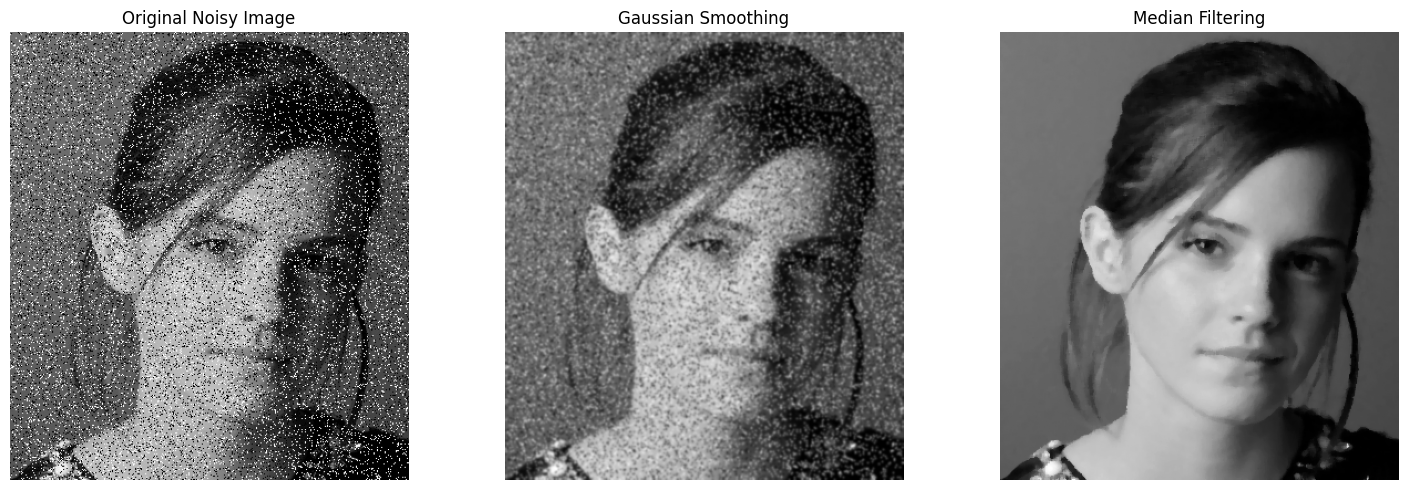

In [7]:
# Load salt & pepper noise image (Fig. 4)
url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/img/emma_salt_pepper (1).jpg"
img_sp = load_image_from_github(url, grayscale=True)

# (a) Gaussian smoothing
img_gaussian = cv.GaussianBlur(img_sp, (5, 5), sigmaX=1)

# (b) Median filtering
img_median = cv.medianBlur(img_sp, 5)

# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_sp, cmap="gray")
plt.title("Original Noisy Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(img_gaussian, cmap="gray")
plt.title("Gaussian Smoothing")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img_median, cmap="gray")
plt.title("Median Filtering")
plt.axis("off")

plt.tight_layout()
plt.show()


Q9)

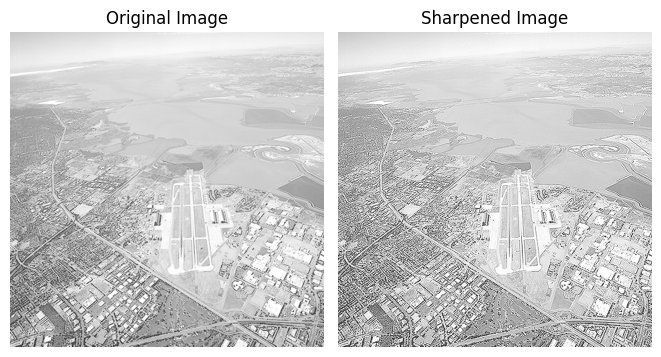

In [18]:

img = runway.copy()

# Sharpening kernel (unsharp mask / high-boost)
sharpen_kernel = np.array([
    [0, -1,  0],
    [-1, 5, -1],
    [0, -1,  0]
])

# Apply sharpening
img_sharpened = cv.filter2D(img, -1, sharpen_kernel)

# Visualization
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(img_sharpened, cmap="gray")
plt.title("Sharpened Image")
plt.axis("off")

plt.tight_layout()
plt.show()


Q10)

(a) — Manual Bilateral Filter (Grayscale)

In [63]:

url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/im03.png"
img_orig = load_image_from_github(url, grayscale=True)

url = "https://raw.githubusercontent.com/NalinDhanuddheera/Intensity-Transformations-and-Neighborhood-Filtering/main/Assignment_1/data/zoom_img/im03small.png"
img_small = load_image_from_github(url, grayscale=True)


In [64]:
if img_small is None:
    raise ValueError("Image failed to load. Check the GitHub raw URL.")


In [65]:
def manual_bilateral_filter(img, d, sigma_s, sigma_r):
    H, W = img.shape
    output_img = np.zeros_like(img)

    pad_size = d // 2
    padded_img = cv.copyMakeBorder(
        img, pad_size, pad_size, pad_size, pad_size, cv.BORDER_REFLECT)

    coords = np.arange(-pad_size, pad_size + 1)
    x, y = np.meshgrid(coords, coords)
    spatial_kernel = np.exp(-(x**2 + y**2) / (2 * sigma_s**2))

    for i in range(H):
        for j in range(W):
            roi = padded_img[i:i+d, j:j+d]
            center_val = padded_img[i + pad_size, j + pad_size]

            intensity_diff = roi - center_val
            range_kernel = np.exp(-(intensity_diff**2) / (2 * sigma_r**2))

            weights = spatial_kernel * range_kernel
            output_img[i, j] = np.sum(weights * roi) / np.sum(weights)

    return np.uint8(output_img)


In [66]:
d = 9
sigma_s = 75
sigma_r = 75

img_bilateral_manual = manual_bilateral_filter(img_small, d, sigma_s, sigma_r)
img_gaussian = cv.GaussianBlur(img_small, (d, d), sigma_s)
img_bilateral_cv = cv.bilateralFilter(img_small, d, sigma_r, sigma_s)


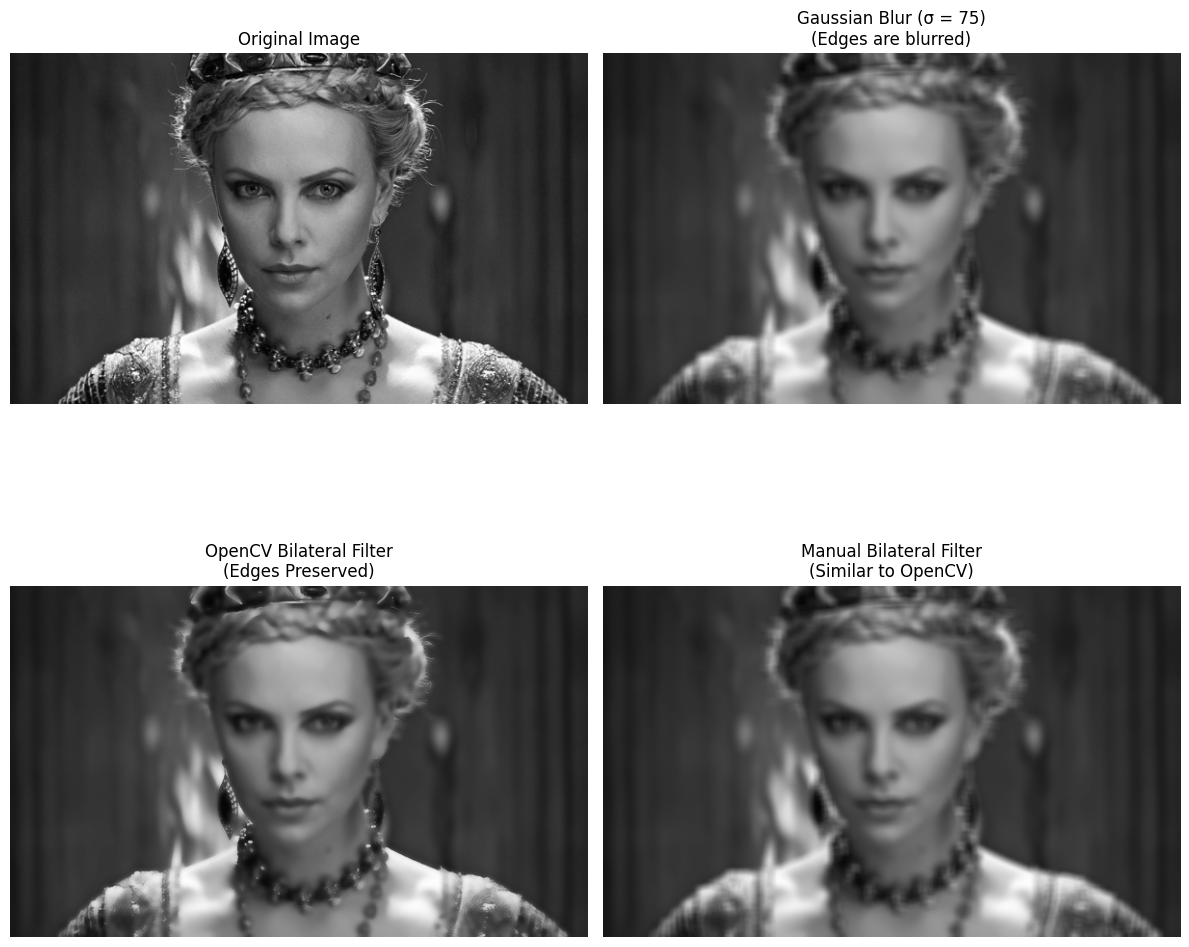

In [67]:
plt.figure(figsize=(12, 12))

# Original Image
plt.subplot(2, 2, 1)
plt.imshow(img_small, cmap='gray', vmin=0, vmax=255)
plt.title('Original Image')
plt.axis('off')

# Gaussian Blur
plt.subplot(2, 2, 2)
plt.imshow(img_gaussian, cmap='gray', vmin=0, vmax=255)
plt.title(f'Gaussian Blur (σ = {sigma_s})\n(Edges are blurred)')
plt.axis('off')

# OpenCV Bilateral Filter
plt.subplot(2, 2, 3)
plt.imshow(img_bilateral_cv, cmap='gray', vmin=0, vmax=255)
plt.title('OpenCV Bilateral Filter\n(Edges Preserved)')
plt.axis('off')

# Manual Bilateral Filter
plt.subplot(2, 2, 4)
plt.imshow(img_bilateral_manual, cmap='gray', vmin=0, vmax=255)
plt.title('Manual Bilateral Filter\n(Similar to OpenCV)')
plt.axis('off')

plt.tight_layout()
plt.show()
